In [123]:
using Random, JuMP, Gurobi, Plots, Distances, AbstractPlotting

┌ Info: Precompiling AbstractPlotting [537997a7-5e4e-5d89-9595-2241ea00577e]
└ @ Base loading.jl:1423
┌ Warning: Module GeometryBasics with build ID 125219107844501 is missing from the cache.
│ This may mean GeometryBasics [5c1252a2-5f33-56bf-86c9-59e7332b4326] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Info: Skipping precompilation since __precompile__(false). Importing AbstractPlotting [537997a7-5e4e-5d89-9595-2241ea00577e].
└ @ Base loading.jl:1124
┌ Info: Precompiling Packing [19eb6ba3-879d-56ad-ad62-d5c202156566]
└ @ Base loading.jl:1423
┌ Warning: Module GeometryBasics with build ID 125219107844501 is missing from the cache.
│ This may mean GeometryBasics [5c1252a2-5f33-56bf-86c9-59e7332b4326] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Info: Skipping precompilation since __precompile__(false). Importing Packing [19eb6ba3-879d-56ad-ad62-d5c202156566].
└ @ Base loading.jl:1

In [6]:
n = 10 # number of locations
Random.seed!(1234)
x_pos = rand(0:10, n)
y_pos = rand(0:10, n);

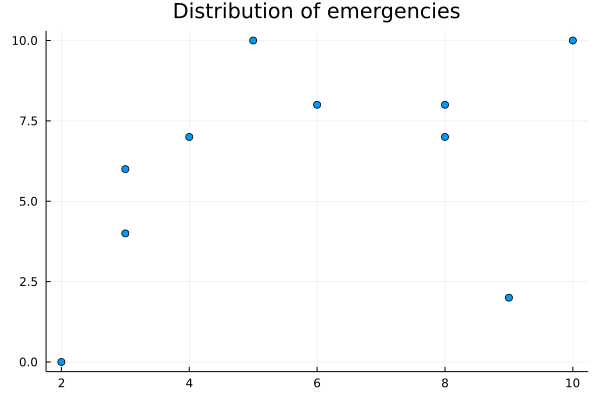

In [7]:
scatter(x_pos, y_pos, title = "Distribution of emergencies", legend = false)

In [228]:
# Parameters

distance = Dict((i,j) => euclidean((x_pos[i], y_pos[i]), (x_pos[j], y_pos[j])) for i = 1:n, j = 1:n);
emergencies = Dict(i => rand(0:10) for i = 1:n);
n_ambulances = 3;

In [230]:
# Sets 
locations = 1:n 
emergency_locations = 1:n;

In [231]:
# Model 
mdl = Model(Gurobi.Optimizer)

# Decision variables
@variable(mdl, x[i in locations, j in emergency_locations], Bin)
@variable(mdl, y[i in locations], Bin);

Set parameter Username
Academic license - for non-commercial use only - expires 2022-07-09


In [232]:
# Objective function

@objective(mdl, Min, sum(distance[i,j] * emergencies[j] * x[i, j] for i in locations, j in emergency_locations));

In [233]:
# Constraints

@constraint(mdl, [j in emergency_locations], sum(x[i,j] for i in locations) == 1);
@constraint(mdl, sum(y[i] for i in locations) <= n_ambulances);
@constraint(mdl, [i in locations, j in emergency_locations], x[i,j] <= y[i] );

In [234]:
# Solving the model 

JuMP.optimize!(mdl)

Z_opt = JuMP.objective_value(mdl)
x_opt = JuMP.value.(x)
y_opt = JuMP.value.(y);

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 111 rows, 110 columns and 310 nonzeros
Model fingerprint: 0x4e52086f
Variable types: 0 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 330.8454349
Presolve time: 0.00s
Presolved: 111 rows, 110 columns, 310 nonzeros
Variable types: 0 continuous, 110 integer (110 binary)
Found heuristic solution: objective 147.7945242

Root relaxation: objective 1.016197e+02, 47 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     101.6196883  101.61969  0.00%     -    0s

Explored 1 nodes (47 simplex

In [235]:
y_opt = [i for i in locations if JuMP.value.(y)[i] >= 0.9]
x_opt = [(i,j) for i in locations, j in emergency_locations if JuMP.value.(x)[i, j] >= 0.9];

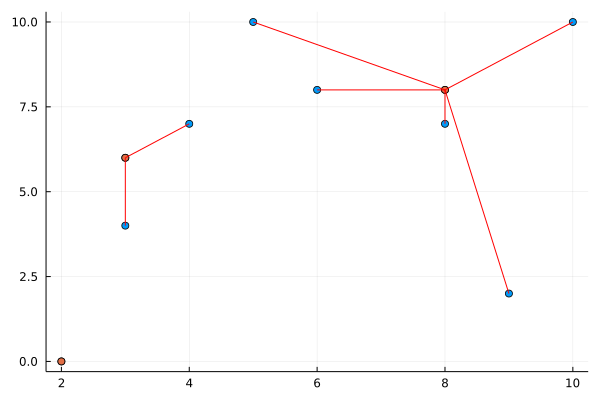

In [239]:
sc1 = scatter(x_pos, y_pos, legend = false)
sc2 = scatter!(x_pos[y_opt], y_pos[y_opt], legend = false)
plot!([[x_pos[x_opt[i][1]], x_pos[x_opt[i][2]]] for i in 1:length(x_opt)], 
[[y_pos[x_opt[i][1]], y_pos[x_opt[i][2]]] for i in 1:length(x_opt)], color="red")
